In [ ]:
 import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
!pip install tqdm
from tqdm import tqdm  # Import tqdm for the progress bar
import random




In [ ]:
# Define a simple neural network for the MNIST dataset
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))

        x = F.dropout(x, training=self.training)

        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

##Standard SGD

In [ ]:
# Function for training with standard mini-batch SGD
def train_standard_sgd(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]: Loss: {loss.item():.6f}")

##Standard SGD (randomly choose m examples from batch b)

In [ ]:
import torch
import torch.nn as nn

# Function for training with standard mini-batch SGD
def train_standard_sgd_random_m(model, device, train_loader, optimizer, epoch, m):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Randomly choose m examples from the batch
        selected_indices = torch.randperm(data.size(0))[:m]
        selected_data = data[selected_indices]
        selected_target = target[selected_indices]

        optimizer.zero_grad()
        output = model(selected_data)
        loss = nn.functional.cross_entropy(output, selected_target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]: Loss: {loss.item():.6f}")


##SGD with forgetting score (sort and choose m examples from batch b)

In [ ]:
# Function for training with mini-batch SGD considering forgetting score
def train_with_forgetting_score(model, device, train_loader, optimizer, epoch, prev_acc, forgetting_T, m):
    model.train()
    total_forgetting_score = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Save predictions
        with torch.no_grad():
            new_output = model(data)
            new_pred = new_output.argmax(dim=1, keepdim=True) #TODO: compute acci should be done in inner for loop


        # Calculate forgetting score for each image in batch
        for i in range(len(data)):

          new_correct = int(new_pred[i].eq(target[i].view_as(new_pred[i])).item())

          index = batch_idx * train_loader.batch_size + i #Get image index
          if prev_acc[index] > new_correct: #previous prediction is correctly classified (true 1) > new prediction misclassified (false 0)
            forgetting_T[index] += 1

          # if prev_acc[index] > new_correct: #check
          #   print(f"index: {index} --- prev predict: {prev_acc[index]} --- new_predict: {new_correct} --- curr forgetting: {forgetting_T[index]}")

          prev_acc[index] = new_correct


        ######
        #m = 10 # len(data) / 2 #choose m from batch B

        # Sort examples by forgetting score in descending order within the batch
        batch_forgetting_scores = [(i, forgetting_T[i]) for i in range(len(data))]
        batch_forgetting_scores = sorted(batch_forgetting_scores, key=lambda x: x[1], reverse=True)

        # Choose the top m examples with the highest forgetting scores within the batch
        selected_examples = [i for i, _ in batch_forgetting_scores[:m]]

        #print(f"score: {batch_forgetting_scores[0][1]} boolean: {(batch_forgetting_scores[0][1] > 1)}")
        # if(batch_forgetting_scores[0][1] >= 1):
        #   print(batch_forgetting_scores)

        # Training on selected examples within the batch
        model.train()
        optimizer.zero_grad()

        # Run only the selected examples through the model
        selected_output = model(data[selected_examples])
        selected_target = target[selected_examples]

        loss = nn.functional.cross_entropy(selected_output, selected_target)
        loss.backward()
        optimizer.step()

        ######


        # # Perform a training step (gradient update classifier on B)
        # optimizer.zero_grad()
        # output = model(data)
        # loss = nn.functional.cross_entropy(output, target)
        # loss.backward()
        # optimizer.step()


    #forgetting score
    epoch_forgetting_score = sum(forgetting_T)
    average_forgetting_score = total_forgetting_score / len(forgetting_T)

    # Print current total forgetting score at the end of each iteration
    print(f'Epoch: {epoch}, Batch: {batch_idx}, Average Forgetting Score: {epoch_forgetting_score}')

    return average_forgetting_score

##SGD with forgetting score (probabilistically determine m examples from batch b)

In [ ]:
# Function for training with mini-batch SGD considering forgetting score
def train_with_forgetting_score_probabilistic(model, device, train_loader, optimizer, epoch, prev_acc, forgetting_T, m):
    model.train()
    total_forgetting_score = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # sample m points from b based on forgetting score
        forgetting_scores = forgetting_T[batch_idx * train_loader.batch_size: batch_idx * train_loader.batch_size + len(data) - 1] + 1
        forgetting_probs = forgetting_scores / sum(forgetting_scores)
        sampled_indices = torch.multinomial(forgetting_probs, m, replacement=False)

        ### weird cuda error ####
        sampled_indices = sampled_indices.to(device)
        #################

        selected_data = torch.index_select(data, 0, sampled_indices)
        selected_target = torch.index_select(target, 0, sampled_indices)

        # Save predictions
        with torch.no_grad():
            new_output = model(selected_data)
            new_pred = new_output.argmax(dim=1, keepdim=True) #TODO: compute acci should be done in inner for loop

        for idx, i in enumerate(sampled_indices):
          new_correct = int(new_pred[idx].eq(selected_target[idx].view_as(new_pred[idx])).item())

          index = batch_idx * train_loader.batch_size + i #Get image index
          if prev_acc[index] > new_correct: #previous prediction is correctly classified (true 1) > new prediction misclassified (false 0)
            forgetting_T[index] += 1

          # if prev_acc[index] > new_correct: #check
          #   print(f"index: {index} --- prev predict: {prev_acc[index]} --- new_predict: {new_correct} --- curr forgetting: {forgetting_T[index]}")

          prev_acc[index] = new_correct

        # Perform a training step (gradient update classifier on B)
        optimizer.zero_grad()
        output = model(selected_data)
        loss = nn.functional.cross_entropy(output, selected_target)
        loss.backward()
        optimizer.step()

    #forgetting score
    epoch_forgetting_score = sum(forgetting_T)
    average_forgetting_score = epoch_forgetting_score / len(forgetting_T)

    # Print current total forgetting score at the end of each iteration
    # print(f'Epoch: {epoch}, Batch: {batch_idx}, Average Forgetting Score: {epoch_forgetting_score}')

    return average_forgetting_score

##Run different methods

In [ ]:
# Function for testing the model on the test dataset
def test_model(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy

# Main function to run the training
def run_training(batch_size, epochs):
    # Check for available device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    prev_acc = torch.zeros_like(train_dataset.targets)
    forgetting_T = torch.zeros_like(train_dataset.targets)
    forgetting_T_p = torch.zeros_like(train_dataset.targets)


    # Initialize models and optimizers
    standard_model = SimpleNN().to(device)
    forgetting_model = SimpleNN().to(device)
    random_model = SimpleNN().to(device)
    optimizer_standard = optim.SGD(standard_model.parameters(), lr=0.01)
    optimizer_forgetting = optim.SGD(forgetting_model.parameters(), lr=0.01)
    optimizer_random = optim.SGD(random_model.parameters(), lr=0.01)

    p_model = SimpleNN().to(device)
    optimizer_p = optim.SGD(p_model.parameters(), lr=0.01)


    # Lists to store test accuracies
    test_accuracies_standard = []
    test_accuracies_forgetting = []
    test_accuracies_random = []
    test_accuracies_p = []

    #choose m examples from batch b
    m = 64

    # Train models
    for epoch in tqdm(range(1, epochs + 1), desc='Epochs'):

        print(f"\nEpoch {epoch} - Standard SGD")
        train_standard_sgd(standard_model, device, train_loader, optimizer_standard, epoch)

        print(f"\nTesting - Standard SGD")
        test_acc_standard = test_model(standard_model, device, test_loader)
        test_accuracies_standard.append(test_acc_standard)

        print(f"\nEpoch {epoch} - Standard SGD w/ Random M Examples")
        train_standard_sgd_random_m(random_model, device, train_loader, optimizer_random, epoch, m)

        print(f"\nTesting - Standard SGD w/ Random M Examples")
        test_acc_random = test_model(random_model, device, test_loader)
        test_accuracies_random.append(test_acc_random)

        print(f"\nEpoch {epoch} - SGD with Forgetting Score")
        avg_forgetting_score = train_with_forgetting_score(forgetting_model, device, train_loader, optimizer_forgetting, epoch, prev_acc, forgetting_T, m)
        print(f"Total Forgetting Score for Epoch {epoch}: {avg_forgetting_score:.4f}")

        print(f"\nTesting - SGD with Forgetting Score")
        test_acc_forgetting = test_model(forgetting_model, device, test_loader)
        test_accuracies_forgetting.append(test_acc_forgetting)

        print(f"\nEpoch {epoch} - Standard SGD w/ Probablisitic M Examples")
        train_with_forgetting_score_probabilistic(p_model, device, train_loader, optimizer_p, epoch, prev_acc, forgetting_T_p, m)

        print(f"\nTesting - Standard SGD w/ Probablisitic M Examples")
        test_acc_p = test_model(p_model, device, test_loader)
        test_accuracies_p.append(test_acc_p)



    return test_accuracies_standard, test_accuracies_forgetting, test_accuracies_random, test_accuracies_p


# Parameters for training
batch_size = 640
epochs = 100

# Start training
test_accuracies_standard, test_accuracies_forgetting, test_accuracies_random, test_accuracies_p = run_training(batch_size, epochs)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1 - Standard SGD
Epoch 1 [0/60000]: Loss: 2.333635

Testing - Standard SGD
Test Accuracy: 0.6862

Epoch 1 - Standard SGD w/ Random M Examples
Epoch 1 [0/60000]: Loss: 2.352720

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.6886

Epoch 1 - SGD with Forgetting Score
Epoch: 1, Batch: 93, Average Forgetting Score: 0
Total Forgetting Score for Epoch 1: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.6948

Epoch 1 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:   1%|          | 1/100 [01:10<1:56:18, 70.49s/it]

Test Accuracy: 0.7459

Epoch 2 - Standard SGD
Epoch 2 [0/60000]: Loss: 1.301217

Testing - Standard SGD
Test Accuracy: 0.8301

Epoch 2 - Standard SGD w/ Random M Examples
Epoch 2 [0/60000]: Loss: 1.329979

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.8137

Epoch 2 - SGD with Forgetting Score
Epoch: 2, Batch: 93, Average Forgetting Score: 6083
Total Forgetting Score for Epoch 2: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.8247

Epoch 2 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:   2%|▏         | 2/100 [02:18<1:53:03, 69.22s/it]

Test Accuracy: 0.8281

Epoch 3 - Standard SGD
Epoch 3 [0/60000]: Loss: 0.756511

Testing - Standard SGD
Test Accuracy: 0.8605

Epoch 3 - Standard SGD w/ Random M Examples
Epoch 3 [0/60000]: Loss: 0.676832

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.8474

Epoch 3 - SGD with Forgetting Score
Epoch: 3, Batch: 93, Average Forgetting Score: 13757
Total Forgetting Score for Epoch 3: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.8530

Epoch 3 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:   3%|▎         | 3/100 [03:28<1:52:11, 69.39s/it]

Test Accuracy: 0.8510

Epoch 4 - Standard SGD
Epoch 4 [0/60000]: Loss: 0.590517

Testing - Standard SGD
Test Accuracy: 0.8778

Epoch 4 - Standard SGD w/ Random M Examples
Epoch 4 [0/60000]: Loss: 0.493856

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.8671

Epoch 4 - SGD with Forgetting Score
Epoch: 4, Batch: 93, Average Forgetting Score: 20834
Total Forgetting Score for Epoch 4: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.8762

Epoch 4 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:   4%|▍         | 4/100 [04:36<1:50:29, 69.06s/it]

Test Accuracy: 0.8671

Epoch 5 - Standard SGD
Epoch 5 [0/60000]: Loss: 0.472383

Testing - Standard SGD
Test Accuracy: 0.8874

Epoch 5 - Standard SGD w/ Random M Examples
Epoch 5 [0/60000]: Loss: 0.630182

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.8741

Epoch 5 - SGD with Forgetting Score
Epoch: 5, Batch: 93, Average Forgetting Score: 27373
Total Forgetting Score for Epoch 5: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.8875

Epoch 5 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:   5%|▌         | 5/100 [05:45<1:49:01, 68.86s/it]

Test Accuracy: 0.8795

Epoch 6 - Standard SGD
Epoch 6 [0/60000]: Loss: 0.435944

Testing - Standard SGD
Test Accuracy: 0.8933

Epoch 6 - Standard SGD w/ Random M Examples
Epoch 6 [0/60000]: Loss: 0.351212

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.8867

Epoch 6 - SGD with Forgetting Score
Epoch: 6, Batch: 93, Average Forgetting Score: 33636
Total Forgetting Score for Epoch 6: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.8900

Epoch 6 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:   6%|▌         | 6/100 [06:56<1:49:14, 69.73s/it]

Test Accuracy: 0.8884

Epoch 7 - Standard SGD
Epoch 7 [0/60000]: Loss: 0.346048

Testing - Standard SGD
Test Accuracy: 0.8970

Epoch 7 - Standard SGD w/ Random M Examples
Epoch 7 [0/60000]: Loss: 0.278128

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.8908

Epoch 7 - SGD with Forgetting Score
Epoch: 7, Batch: 93, Average Forgetting Score: 39546
Total Forgetting Score for Epoch 7: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.8975

Epoch 7 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:   7%|▋         | 7/100 [08:05<1:47:32, 69.38s/it]

Test Accuracy: 0.8929

Epoch 8 - Standard SGD
Epoch 8 [0/60000]: Loss: 0.401497

Testing - Standard SGD
Test Accuracy: 0.9003

Epoch 8 - Standard SGD w/ Random M Examples
Epoch 8 [0/60000]: Loss: 0.372120

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.8935

Epoch 8 - SGD with Forgetting Score
Epoch: 8, Batch: 93, Average Forgetting Score: 45209
Total Forgetting Score for Epoch 8: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9007

Epoch 8 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:   8%|▊         | 8/100 [09:12<1:45:20, 68.70s/it]

Test Accuracy: 0.8963

Epoch 9 - Standard SGD
Epoch 9 [0/60000]: Loss: 0.389050

Testing - Standard SGD
Test Accuracy: 0.9040

Epoch 9 - Standard SGD w/ Random M Examples
Epoch 9 [0/60000]: Loss: 0.307414

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.8982

Epoch 9 - SGD with Forgetting Score
Epoch: 9, Batch: 93, Average Forgetting Score: 50847
Total Forgetting Score for Epoch 9: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9031

Epoch 9 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:   9%|▉         | 9/100 [10:19<1:43:14, 68.08s/it]

Test Accuracy: 0.8959

Epoch 10 - Standard SGD
Epoch 10 [0/60000]: Loss: 0.369218

Testing - Standard SGD
Test Accuracy: 0.9052

Epoch 10 - Standard SGD w/ Random M Examples
Epoch 10 [0/60000]: Loss: 0.211475

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9000

Epoch 10 - SGD with Forgetting Score
Epoch: 10, Batch: 93, Average Forgetting Score: 56297
Total Forgetting Score for Epoch 10: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9057

Epoch 10 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  10%|█         | 10/100 [11:25<1:41:21, 67.57s/it]

Test Accuracy: 0.9010

Epoch 11 - Standard SGD
Epoch 11 [0/60000]: Loss: 0.398909

Testing - Standard SGD
Test Accuracy: 0.9077

Epoch 11 - Standard SGD w/ Random M Examples
Epoch 11 [0/60000]: Loss: 0.394630

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9030

Epoch 11 - SGD with Forgetting Score
Epoch: 11, Batch: 93, Average Forgetting Score: 61611
Total Forgetting Score for Epoch 11: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9082

Epoch 11 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  11%|█         | 11/100 [12:33<1:40:16, 67.60s/it]

Test Accuracy: 0.9017

Epoch 12 - Standard SGD
Epoch 12 [0/60000]: Loss: 0.353218

Testing - Standard SGD
Test Accuracy: 0.9091

Epoch 12 - Standard SGD w/ Random M Examples
Epoch 12 [0/60000]: Loss: 0.298340

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9044

Epoch 12 - SGD with Forgetting Score
Epoch: 12, Batch: 93, Average Forgetting Score: 66855
Total Forgetting Score for Epoch 12: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9117

Epoch 12 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  12%|█▏        | 12/100 [13:39<1:38:29, 67.15s/it]

Test Accuracy: 0.9041

Epoch 13 - Standard SGD
Epoch 13 [0/60000]: Loss: 0.351486

Testing - Standard SGD
Test Accuracy: 0.9123

Epoch 13 - Standard SGD w/ Random M Examples
Epoch 13 [0/60000]: Loss: 0.492962

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9024

Epoch 13 - SGD with Forgetting Score
Epoch: 13, Batch: 93, Average Forgetting Score: 71970
Total Forgetting Score for Epoch 13: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9119

Epoch 13 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  13%|█▎        | 13/100 [14:44<1:36:31, 66.57s/it]

Test Accuracy: 0.9060

Epoch 14 - Standard SGD
Epoch 14 [0/60000]: Loss: 0.345654

Testing - Standard SGD
Test Accuracy: 0.9130

Epoch 14 - Standard SGD w/ Random M Examples
Epoch 14 [0/60000]: Loss: 0.288605

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9064

Epoch 14 - SGD with Forgetting Score
Epoch: 14, Batch: 93, Average Forgetting Score: 77118
Total Forgetting Score for Epoch 14: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9122

Epoch 14 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  14%|█▍        | 14/100 [15:51<1:35:13, 66.44s/it]

Test Accuracy: 0.9070

Epoch 15 - Standard SGD
Epoch 15 [0/60000]: Loss: 0.294306

Testing - Standard SGD
Test Accuracy: 0.9171

Epoch 15 - Standard SGD w/ Random M Examples
Epoch 15 [0/60000]: Loss: 0.511433

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9080

Epoch 15 - SGD with Forgetting Score
Epoch: 15, Batch: 93, Average Forgetting Score: 82113
Total Forgetting Score for Epoch 15: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9112

Epoch 15 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  15%|█▌        | 15/100 [16:57<1:33:55, 66.30s/it]

Test Accuracy: 0.9071

Epoch 16 - Standard SGD
Epoch 16 [0/60000]: Loss: 0.349669

Testing - Standard SGD
Test Accuracy: 0.9193

Epoch 16 - Standard SGD w/ Random M Examples
Epoch 16 [0/60000]: Loss: 0.367203

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9074

Epoch 16 - SGD with Forgetting Score
Epoch: 16, Batch: 93, Average Forgetting Score: 87094
Total Forgetting Score for Epoch 16: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9147

Epoch 16 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  16%|█▌        | 16/100 [18:04<1:33:13, 66.59s/it]

Test Accuracy: 0.9084

Epoch 17 - Standard SGD
Epoch 17 [0/60000]: Loss: 0.323113

Testing - Standard SGD
Test Accuracy: 0.9205

Epoch 17 - Standard SGD w/ Random M Examples
Epoch 17 [0/60000]: Loss: 0.347070

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9091

Epoch 17 - SGD with Forgetting Score
Epoch: 17, Batch: 93, Average Forgetting Score: 91965
Total Forgetting Score for Epoch 17: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9151

Epoch 17 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  17%|█▋        | 17/100 [19:10<1:31:54, 66.44s/it]

Test Accuracy: 0.9077

Epoch 18 - Standard SGD
Epoch 18 [0/60000]: Loss: 0.348704

Testing - Standard SGD
Test Accuracy: 0.9211

Epoch 18 - Standard SGD w/ Random M Examples
Epoch 18 [0/60000]: Loss: 0.497932

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9119

Epoch 18 - SGD with Forgetting Score
Epoch: 18, Batch: 93, Average Forgetting Score: 96855
Total Forgetting Score for Epoch 18: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9166

Epoch 18 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  18%|█▊        | 18/100 [20:14<1:30:00, 65.86s/it]

Test Accuracy: 0.9102

Epoch 19 - Standard SGD
Epoch 19 [0/60000]: Loss: 0.280339

Testing - Standard SGD
Test Accuracy: 0.9226

Epoch 19 - Standard SGD w/ Random M Examples
Epoch 19 [0/60000]: Loss: 0.258921

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9142

Epoch 19 - SGD with Forgetting Score
Epoch: 19, Batch: 93, Average Forgetting Score: 101725
Total Forgetting Score for Epoch 19: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9189

Epoch 19 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  19%|█▉        | 19/100 [21:20<1:28:46, 65.76s/it]

Test Accuracy: 0.9119

Epoch 20 - Standard SGD
Epoch 20 [0/60000]: Loss: 0.335951

Testing - Standard SGD
Test Accuracy: 0.9234

Epoch 20 - Standard SGD w/ Random M Examples
Epoch 20 [0/60000]: Loss: 0.326853

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9154

Epoch 20 - SGD with Forgetting Score
Epoch: 20, Batch: 93, Average Forgetting Score: 106512
Total Forgetting Score for Epoch 20: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9171

Epoch 20 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  20%|██        | 20/100 [22:28<1:28:45, 66.57s/it]

Test Accuracy: 0.9147

Epoch 21 - Standard SGD
Epoch 21 [0/60000]: Loss: 0.289037

Testing - Standard SGD
Test Accuracy: 0.9235

Epoch 21 - Standard SGD w/ Random M Examples
Epoch 21 [0/60000]: Loss: 0.349065

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9142

Epoch 21 - SGD with Forgetting Score
Epoch: 21, Batch: 93, Average Forgetting Score: 111313
Total Forgetting Score for Epoch 21: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9185

Epoch 21 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  21%|██        | 21/100 [23:36<1:27:57, 66.80s/it]

Test Accuracy: 0.9160

Epoch 22 - Standard SGD
Epoch 22 [0/60000]: Loss: 0.270619

Testing - Standard SGD
Test Accuracy: 0.9244

Epoch 22 - Standard SGD w/ Random M Examples
Epoch 22 [0/60000]: Loss: 0.475922

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9150

Epoch 22 - SGD with Forgetting Score
Epoch: 22, Batch: 93, Average Forgetting Score: 116002
Total Forgetting Score for Epoch 22: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9167

Epoch 22 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  22%|██▏       | 22/100 [24:42<1:26:47, 66.77s/it]

Test Accuracy: 0.9167

Epoch 23 - Standard SGD
Epoch 23 [0/60000]: Loss: 0.282194

Testing - Standard SGD
Test Accuracy: 0.9262

Epoch 23 - Standard SGD w/ Random M Examples
Epoch 23 [0/60000]: Loss: 0.342837

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9166

Epoch 23 - SGD with Forgetting Score
Epoch: 23, Batch: 93, Average Forgetting Score: 120663
Total Forgetting Score for Epoch 23: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9201

Epoch 23 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  23%|██▎       | 23/100 [25:50<1:25:58, 67.00s/it]

Test Accuracy: 0.9152

Epoch 24 - Standard SGD
Epoch 24 [0/60000]: Loss: 0.362650

Testing - Standard SGD
Test Accuracy: 0.9257

Epoch 24 - Standard SGD w/ Random M Examples
Epoch 24 [0/60000]: Loss: 0.300314

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9174

Epoch 24 - SGD with Forgetting Score
Epoch: 24, Batch: 93, Average Forgetting Score: 125290
Total Forgetting Score for Epoch 24: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9203

Epoch 24 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  24%|██▍       | 24/100 [26:57<1:25:01, 67.12s/it]

Test Accuracy: 0.9165

Epoch 25 - Standard SGD
Epoch 25 [0/60000]: Loss: 0.245034

Testing - Standard SGD
Test Accuracy: 0.9263

Epoch 25 - Standard SGD w/ Random M Examples
Epoch 25 [0/60000]: Loss: 0.300340

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9194

Epoch 25 - SGD with Forgetting Score
Epoch: 25, Batch: 93, Average Forgetting Score: 129840
Total Forgetting Score for Epoch 25: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9215

Epoch 25 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  25%|██▌       | 25/100 [28:05<1:24:12, 67.36s/it]

Test Accuracy: 0.9166

Epoch 26 - Standard SGD
Epoch 26 [0/60000]: Loss: 0.298751

Testing - Standard SGD
Test Accuracy: 0.9274

Epoch 26 - Standard SGD w/ Random M Examples
Epoch 26 [0/60000]: Loss: 0.155289

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9184

Epoch 26 - SGD with Forgetting Score
Epoch: 26, Batch: 93, Average Forgetting Score: 134352
Total Forgetting Score for Epoch 26: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9205

Epoch 26 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  26%|██▌       | 26/100 [29:12<1:22:54, 67.22s/it]

Test Accuracy: 0.9189

Epoch 27 - Standard SGD
Epoch 27 [0/60000]: Loss: 0.227229

Testing - Standard SGD
Test Accuracy: 0.9286

Epoch 27 - Standard SGD w/ Random M Examples
Epoch 27 [0/60000]: Loss: 0.326546

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9207

Epoch 27 - SGD with Forgetting Score
Epoch: 27, Batch: 93, Average Forgetting Score: 138925
Total Forgetting Score for Epoch 27: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9194

Epoch 27 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  27%|██▋       | 27/100 [30:18<1:21:26, 66.94s/it]

Test Accuracy: 0.9192

Epoch 28 - Standard SGD
Epoch 28 [0/60000]: Loss: 0.260410

Testing - Standard SGD
Test Accuracy: 0.9281

Epoch 28 - Standard SGD w/ Random M Examples
Epoch 28 [0/60000]: Loss: 0.209985

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9211

Epoch 28 - SGD with Forgetting Score
Epoch: 28, Batch: 93, Average Forgetting Score: 143427
Total Forgetting Score for Epoch 28: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9222

Epoch 28 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  28%|██▊       | 28/100 [31:24<1:19:53, 66.57s/it]

Test Accuracy: 0.9201

Epoch 29 - Standard SGD
Epoch 29 [0/60000]: Loss: 0.321993

Testing - Standard SGD
Test Accuracy: 0.9285

Epoch 29 - Standard SGD w/ Random M Examples
Epoch 29 [0/60000]: Loss: 0.282618

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9196

Epoch 29 - SGD with Forgetting Score
Epoch: 29, Batch: 93, Average Forgetting Score: 147895
Total Forgetting Score for Epoch 29: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9245

Epoch 29 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  29%|██▉       | 29/100 [32:32<1:19:13, 66.95s/it]

Test Accuracy: 0.9195

Epoch 30 - Standard SGD
Epoch 30 [0/60000]: Loss: 0.309978

Testing - Standard SGD
Test Accuracy: 0.9289

Epoch 30 - Standard SGD w/ Random M Examples
Epoch 30 [0/60000]: Loss: 0.335310

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9221

Epoch 30 - SGD with Forgetting Score
Epoch: 30, Batch: 93, Average Forgetting Score: 152322
Total Forgetting Score for Epoch 30: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9221

Epoch 30 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  30%|███       | 30/100 [33:41<1:18:51, 67.59s/it]

Test Accuracy: 0.9204

Epoch 31 - Standard SGD
Epoch 31 [0/60000]: Loss: 0.211954

Testing - Standard SGD
Test Accuracy: 0.9295

Epoch 31 - Standard SGD w/ Random M Examples
Epoch 31 [0/60000]: Loss: 0.169560

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9233

Epoch 31 - SGD with Forgetting Score
Epoch: 31, Batch: 93, Average Forgetting Score: 156689
Total Forgetting Score for Epoch 31: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9244

Epoch 31 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  31%|███       | 31/100 [34:50<1:18:16, 68.06s/it]

Test Accuracy: 0.9209

Epoch 32 - Standard SGD
Epoch 32 [0/60000]: Loss: 0.292903

Testing - Standard SGD
Test Accuracy: 0.9307

Epoch 32 - Standard SGD w/ Random M Examples
Epoch 32 [0/60000]: Loss: 0.169269

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9196

Epoch 32 - SGD with Forgetting Score
Epoch: 32, Batch: 93, Average Forgetting Score: 161054
Total Forgetting Score for Epoch 32: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9249

Epoch 32 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  32%|███▏      | 32/100 [35:58<1:17:03, 67.99s/it]

Test Accuracy: 0.9215

Epoch 33 - Standard SGD
Epoch 33 [0/60000]: Loss: 0.213675

Testing - Standard SGD
Test Accuracy: 0.9317

Epoch 33 - Standard SGD w/ Random M Examples
Epoch 33 [0/60000]: Loss: 0.190232

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9226

Epoch 33 - SGD with Forgetting Score
Epoch: 33, Batch: 93, Average Forgetting Score: 165423
Total Forgetting Score for Epoch 33: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9247

Epoch 33 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  33%|███▎      | 33/100 [37:06<1:15:59, 68.05s/it]

Test Accuracy: 0.9207

Epoch 34 - Standard SGD
Epoch 34 [0/60000]: Loss: 0.278754

Testing - Standard SGD
Test Accuracy: 0.9317

Epoch 34 - Standard SGD w/ Random M Examples
Epoch 34 [0/60000]: Loss: 0.116548

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9243

Epoch 34 - SGD with Forgetting Score
Epoch: 34, Batch: 93, Average Forgetting Score: 169757
Total Forgetting Score for Epoch 34: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9257

Epoch 34 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  34%|███▍      | 34/100 [38:12<1:14:03, 67.33s/it]

Test Accuracy: 0.9224

Epoch 35 - Standard SGD
Epoch 35 [0/60000]: Loss: 0.303305

Testing - Standard SGD
Test Accuracy: 0.9313

Epoch 35 - Standard SGD w/ Random M Examples
Epoch 35 [0/60000]: Loss: 0.126050

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9226

Epoch 35 - SGD with Forgetting Score
Epoch: 35, Batch: 93, Average Forgetting Score: 173985
Total Forgetting Score for Epoch 35: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9258

Epoch 35 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  35%|███▌      | 35/100 [39:18<1:12:38, 67.06s/it]

Test Accuracy: 0.9205

Epoch 36 - Standard SGD
Epoch 36 [0/60000]: Loss: 0.287909

Testing - Standard SGD
Test Accuracy: 0.9312

Epoch 36 - Standard SGD w/ Random M Examples
Epoch 36 [0/60000]: Loss: 0.230703

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9255

Epoch 36 - SGD with Forgetting Score
Epoch: 36, Batch: 93, Average Forgetting Score: 178181
Total Forgetting Score for Epoch 36: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9265

Epoch 36 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  36%|███▌      | 36/100 [40:25<1:11:22, 66.92s/it]

Test Accuracy: 0.9238

Epoch 37 - Standard SGD
Epoch 37 [0/60000]: Loss: 0.249129

Testing - Standard SGD
Test Accuracy: 0.9322

Epoch 37 - Standard SGD w/ Random M Examples
Epoch 37 [0/60000]: Loss: 0.309472

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9265

Epoch 37 - SGD with Forgetting Score
Epoch: 37, Batch: 93, Average Forgetting Score: 182408
Total Forgetting Score for Epoch 37: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9257

Epoch 37 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  37%|███▋      | 37/100 [41:32<1:10:20, 66.98s/it]

Test Accuracy: 0.9228

Epoch 38 - Standard SGD
Epoch 38 [0/60000]: Loss: 0.211415

Testing - Standard SGD
Test Accuracy: 0.9325

Epoch 38 - Standard SGD w/ Random M Examples
Epoch 38 [0/60000]: Loss: 0.247164

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9251

Epoch 38 - SGD with Forgetting Score
Epoch: 38, Batch: 93, Average Forgetting Score: 186619
Total Forgetting Score for Epoch 38: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9268

Epoch 38 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  38%|███▊      | 38/100 [42:39<1:09:12, 66.97s/it]

Test Accuracy: 0.9229

Epoch 39 - Standard SGD
Epoch 39 [0/60000]: Loss: 0.283509

Testing - Standard SGD
Test Accuracy: 0.9330

Epoch 39 - Standard SGD w/ Random M Examples
Epoch 39 [0/60000]: Loss: 0.408876

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9273

Epoch 39 - SGD with Forgetting Score
Epoch: 39, Batch: 93, Average Forgetting Score: 190785
Total Forgetting Score for Epoch 39: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9267

Epoch 39 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  39%|███▉      | 39/100 [43:45<1:07:37, 66.52s/it]

Test Accuracy: 0.9237

Epoch 40 - Standard SGD
Epoch 40 [0/60000]: Loss: 0.277106

Testing - Standard SGD
Test Accuracy: 0.9329

Epoch 40 - Standard SGD w/ Random M Examples
Epoch 40 [0/60000]: Loss: 0.376993

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9252

Epoch 40 - SGD with Forgetting Score
Epoch: 40, Batch: 93, Average Forgetting Score: 194914
Total Forgetting Score for Epoch 40: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9271

Epoch 40 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  40%|████      | 40/100 [44:48<1:05:40, 65.67s/it]

Test Accuracy: 0.9221

Epoch 41 - Standard SGD
Epoch 41 [0/60000]: Loss: 0.242081

Testing - Standard SGD
Test Accuracy: 0.9339

Epoch 41 - Standard SGD w/ Random M Examples
Epoch 41 [0/60000]: Loss: 0.266022

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9264

Epoch 41 - SGD with Forgetting Score
Epoch: 41, Batch: 93, Average Forgetting Score: 198988
Total Forgetting Score for Epoch 41: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9282

Epoch 41 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  41%|████      | 41/100 [45:53<1:04:14, 65.33s/it]

Test Accuracy: 0.9244

Epoch 42 - Standard SGD
Epoch 42 [0/60000]: Loss: 0.277095

Testing - Standard SGD
Test Accuracy: 0.9332

Epoch 42 - Standard SGD w/ Random M Examples
Epoch 42 [0/60000]: Loss: 0.280763

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9281

Epoch 42 - SGD with Forgetting Score
Epoch: 42, Batch: 93, Average Forgetting Score: 203005
Total Forgetting Score for Epoch 42: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9284

Epoch 42 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  42%|████▏     | 42/100 [46:59<1:03:33, 65.75s/it]

Test Accuracy: 0.9249

Epoch 43 - Standard SGD
Epoch 43 [0/60000]: Loss: 0.213302

Testing - Standard SGD
Test Accuracy: 0.9340

Epoch 43 - Standard SGD w/ Random M Examples
Epoch 43 [0/60000]: Loss: 0.257806

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9278

Epoch 43 - SGD with Forgetting Score
Epoch: 43, Batch: 93, Average Forgetting Score: 207070
Total Forgetting Score for Epoch 43: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9298

Epoch 43 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  43%|████▎     | 43/100 [48:05<1:02:20, 65.63s/it]

Test Accuracy: 0.9243

Epoch 44 - Standard SGD
Epoch 44 [0/60000]: Loss: 0.223398

Testing - Standard SGD
Test Accuracy: 0.9351

Epoch 44 - Standard SGD w/ Random M Examples
Epoch 44 [0/60000]: Loss: 0.146397

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9297

Epoch 44 - SGD with Forgetting Score
Epoch: 44, Batch: 93, Average Forgetting Score: 211066
Total Forgetting Score for Epoch 44: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9286

Epoch 44 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  44%|████▍     | 44/100 [49:10<1:01:05, 65.46s/it]

Test Accuracy: 0.9255

Epoch 45 - Standard SGD
Epoch 45 [0/60000]: Loss: 0.255967

Testing - Standard SGD
Test Accuracy: 0.9358

Epoch 45 - Standard SGD w/ Random M Examples
Epoch 45 [0/60000]: Loss: 0.326273

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9281

Epoch 45 - SGD with Forgetting Score
Epoch: 45, Batch: 93, Average Forgetting Score: 215091
Total Forgetting Score for Epoch 45: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9307

Epoch 45 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  45%|████▌     | 45/100 [50:15<59:51, 65.31s/it]  

Test Accuracy: 0.9254

Epoch 46 - Standard SGD
Epoch 46 [0/60000]: Loss: 0.206385

Testing - Standard SGD
Test Accuracy: 0.9352

Epoch 46 - Standard SGD w/ Random M Examples
Epoch 46 [0/60000]: Loss: 0.210658

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9288

Epoch 46 - SGD with Forgetting Score
Epoch: 46, Batch: 93, Average Forgetting Score: 219052
Total Forgetting Score for Epoch 46: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9293

Epoch 46 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  46%|████▌     | 46/100 [51:20<58:46, 65.30s/it]

Test Accuracy: 0.9254

Epoch 47 - Standard SGD
Epoch 47 [0/60000]: Loss: 0.264387

Testing - Standard SGD
Test Accuracy: 0.9353

Epoch 47 - Standard SGD w/ Random M Examples
Epoch 47 [0/60000]: Loss: 0.386994

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9295

Epoch 47 - SGD with Forgetting Score
Epoch: 47, Batch: 93, Average Forgetting Score: 223022
Total Forgetting Score for Epoch 47: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9301

Epoch 47 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  47%|████▋     | 47/100 [52:27<58:03, 65.72s/it]

Test Accuracy: 0.9269

Epoch 48 - Standard SGD
Epoch 48 [0/60000]: Loss: 0.208913

Testing - Standard SGD
Test Accuracy: 0.9362

Epoch 48 - Standard SGD w/ Random M Examples
Epoch 48 [0/60000]: Loss: 0.307609

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9293

Epoch 48 - SGD with Forgetting Score
Epoch: 48, Batch: 93, Average Forgetting Score: 226959
Total Forgetting Score for Epoch 48: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9288

Epoch 48 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  48%|████▊     | 48/100 [53:31<56:36, 65.31s/it]

Test Accuracy: 0.9270

Epoch 49 - Standard SGD
Epoch 49 [0/60000]: Loss: 0.178097

Testing - Standard SGD
Test Accuracy: 0.9371

Epoch 49 - Standard SGD w/ Random M Examples
Epoch 49 [0/60000]: Loss: 0.070141

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9309

Epoch 49 - SGD with Forgetting Score
Epoch: 49, Batch: 93, Average Forgetting Score: 230841
Total Forgetting Score for Epoch 49: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9304

Epoch 49 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  49%|████▉     | 49/100 [54:36<55:22, 65.14s/it]

Test Accuracy: 0.9288

Epoch 50 - Standard SGD
Epoch 50 [0/60000]: Loss: 0.218830

Testing - Standard SGD
Test Accuracy: 0.9365

Epoch 50 - Standard SGD w/ Random M Examples
Epoch 50 [0/60000]: Loss: 0.170940

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9294

Epoch 50 - SGD with Forgetting Score
Epoch: 50, Batch: 93, Average Forgetting Score: 234705
Total Forgetting Score for Epoch 50: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9302

Epoch 50 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  50%|█████     | 50/100 [55:41<54:23, 65.26s/it]

Test Accuracy: 0.9300

Epoch 51 - Standard SGD
Epoch 51 [0/60000]: Loss: 0.222142

Testing - Standard SGD
Test Accuracy: 0.9365

Epoch 51 - Standard SGD w/ Random M Examples
Epoch 51 [0/60000]: Loss: 0.067679

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9310

Epoch 51 - SGD with Forgetting Score
Epoch: 51, Batch: 93, Average Forgetting Score: 238508
Total Forgetting Score for Epoch 51: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9308

Epoch 51 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  51%|█████     | 51/100 [56:48<53:34, 65.60s/it]

Test Accuracy: 0.9286

Epoch 52 - Standard SGD
Epoch 52 [0/60000]: Loss: 0.220814

Testing - Standard SGD
Test Accuracy: 0.9360

Epoch 52 - Standard SGD w/ Random M Examples
Epoch 52 [0/60000]: Loss: 0.203499

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9280

Epoch 52 - SGD with Forgetting Score
Epoch: 52, Batch: 93, Average Forgetting Score: 242325
Total Forgetting Score for Epoch 52: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9337

Epoch 52 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  52%|█████▏    | 52/100 [57:55<52:50, 66.04s/it]

Test Accuracy: 0.9291

Epoch 53 - Standard SGD
Epoch 53 [0/60000]: Loss: 0.216708

Testing - Standard SGD
Test Accuracy: 0.9371

Epoch 53 - Standard SGD w/ Random M Examples
Epoch 53 [0/60000]: Loss: 0.329155

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9297

Epoch 53 - SGD with Forgetting Score
Epoch: 53, Batch: 93, Average Forgetting Score: 246152
Total Forgetting Score for Epoch 53: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9321

Epoch 53 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  53%|█████▎    | 53/100 [59:00<51:26, 65.68s/it]

Test Accuracy: 0.9291

Epoch 54 - Standard SGD
Epoch 54 [0/60000]: Loss: 0.176248

Testing - Standard SGD
Test Accuracy: 0.9376

Epoch 54 - Standard SGD w/ Random M Examples
Epoch 54 [0/60000]: Loss: 0.376009

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9308

Epoch 54 - SGD with Forgetting Score
Epoch: 54, Batch: 93, Average Forgetting Score: 249933
Total Forgetting Score for Epoch 54: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9310

Epoch 54 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  54%|█████▍    | 54/100 [1:00:06<50:23, 65.73s/it]

Test Accuracy: 0.9297

Epoch 55 - Standard SGD
Epoch 55 [0/60000]: Loss: 0.223896

Testing - Standard SGD
Test Accuracy: 0.9375

Epoch 55 - Standard SGD w/ Random M Examples
Epoch 55 [0/60000]: Loss: 0.202031

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9319

Epoch 55 - SGD with Forgetting Score
Epoch: 55, Batch: 93, Average Forgetting Score: 253718
Total Forgetting Score for Epoch 55: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9312

Epoch 55 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  55%|█████▌    | 55/100 [1:01:12<49:24, 65.88s/it]

Test Accuracy: 0.9303

Epoch 56 - Standard SGD
Epoch 56 [0/60000]: Loss: 0.173525

Testing - Standard SGD
Test Accuracy: 0.9378

Epoch 56 - Standard SGD w/ Random M Examples
Epoch 56 [0/60000]: Loss: 0.166103

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9307

Epoch 56 - SGD with Forgetting Score
Epoch: 56, Batch: 93, Average Forgetting Score: 257416
Total Forgetting Score for Epoch 56: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9325

Epoch 56 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  56%|█████▌    | 56/100 [1:02:19<48:37, 66.31s/it]

Test Accuracy: 0.9300

Epoch 57 - Standard SGD
Epoch 57 [0/60000]: Loss: 0.210337

Testing - Standard SGD
Test Accuracy: 0.9383

Epoch 57 - Standard SGD w/ Random M Examples
Epoch 57 [0/60000]: Loss: 0.166997

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9323

Epoch 57 - SGD with Forgetting Score
Epoch: 57, Batch: 93, Average Forgetting Score: 261121
Total Forgetting Score for Epoch 57: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9327

Epoch 57 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  57%|█████▋    | 57/100 [1:03:26<47:33, 66.36s/it]

Test Accuracy: 0.9282

Epoch 58 - Standard SGD
Epoch 58 [0/60000]: Loss: 0.271167

Testing - Standard SGD
Test Accuracy: 0.9384

Epoch 58 - Standard SGD w/ Random M Examples
Epoch 58 [0/60000]: Loss: 0.160883

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9304

Epoch 58 - SGD with Forgetting Score
Epoch: 58, Batch: 93, Average Forgetting Score: 264835
Total Forgetting Score for Epoch 58: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9323

Epoch 58 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  58%|█████▊    | 58/100 [1:04:32<46:31, 66.45s/it]

Test Accuracy: 0.9296

Epoch 59 - Standard SGD
Epoch 59 [0/60000]: Loss: 0.235483

Testing - Standard SGD
Test Accuracy: 0.9381

Epoch 59 - Standard SGD w/ Random M Examples
Epoch 59 [0/60000]: Loss: 0.261174

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9319

Epoch 59 - SGD with Forgetting Score
Epoch: 59, Batch: 93, Average Forgetting Score: 268539
Total Forgetting Score for Epoch 59: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9335

Epoch 59 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  59%|█████▉    | 59/100 [1:05:37<45:07, 66.04s/it]

Test Accuracy: 0.9308

Epoch 60 - Standard SGD
Epoch 60 [0/60000]: Loss: 0.213636

Testing - Standard SGD
Test Accuracy: 0.9387

Epoch 60 - Standard SGD w/ Random M Examples
Epoch 60 [0/60000]: Loss: 0.257826

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9332

Epoch 60 - SGD with Forgetting Score
Epoch: 60, Batch: 93, Average Forgetting Score: 272226
Total Forgetting Score for Epoch 60: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9326

Epoch 60 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  60%|██████    | 60/100 [1:06:43<43:53, 65.83s/it]

Test Accuracy: 0.9304

Epoch 61 - Standard SGD
Epoch 61 [0/60000]: Loss: 0.217788

Testing - Standard SGD
Test Accuracy: 0.9387

Epoch 61 - Standard SGD w/ Random M Examples
Epoch 61 [0/60000]: Loss: 0.269879

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9340

Epoch 61 - SGD with Forgetting Score
Epoch: 61, Batch: 93, Average Forgetting Score: 275853
Total Forgetting Score for Epoch 61: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9342

Epoch 61 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  61%|██████    | 61/100 [1:07:49<42:57, 66.09s/it]

Test Accuracy: 0.9305

Epoch 62 - Standard SGD
Epoch 62 [0/60000]: Loss: 0.201892

Testing - Standard SGD
Test Accuracy: 0.9385

Epoch 62 - Standard SGD w/ Random M Examples
Epoch 62 [0/60000]: Loss: 0.101861

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9339

Epoch 62 - SGD with Forgetting Score
Epoch: 62, Batch: 93, Average Forgetting Score: 279483
Total Forgetting Score for Epoch 62: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9338

Epoch 62 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  62%|██████▏   | 62/100 [1:08:55<41:48, 66.00s/it]

Test Accuracy: 0.9297

Epoch 63 - Standard SGD
Epoch 63 [0/60000]: Loss: 0.215514

Testing - Standard SGD
Test Accuracy: 0.9402

Epoch 63 - Standard SGD w/ Random M Examples
Epoch 63 [0/60000]: Loss: 0.083378

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9343

Epoch 63 - SGD with Forgetting Score
Epoch: 63, Batch: 93, Average Forgetting Score: 283130
Total Forgetting Score for Epoch 63: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9341

Epoch 63 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  63%|██████▎   | 63/100 [1:10:01<40:39, 65.93s/it]

Test Accuracy: 0.9309

Epoch 64 - Standard SGD
Epoch 64 [0/60000]: Loss: 0.238692

Testing - Standard SGD
Test Accuracy: 0.9392

Epoch 64 - Standard SGD w/ Random M Examples
Epoch 64 [0/60000]: Loss: 0.359849

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9339

Epoch 64 - SGD with Forgetting Score
Epoch: 64, Batch: 93, Average Forgetting Score: 286767
Total Forgetting Score for Epoch 64: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9356

Epoch 64 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  64%|██████▍   | 64/100 [1:11:06<39:20, 65.56s/it]

Test Accuracy: 0.9324

Epoch 65 - Standard SGD
Epoch 65 [0/60000]: Loss: 0.218334

Testing - Standard SGD
Test Accuracy: 0.9401

Epoch 65 - Standard SGD w/ Random M Examples
Epoch 65 [0/60000]: Loss: 0.400805

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9338

Epoch 65 - SGD with Forgetting Score
Epoch: 65, Batch: 93, Average Forgetting Score: 290418
Total Forgetting Score for Epoch 65: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9347

Epoch 65 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  65%|██████▌   | 65/100 [1:12:11<38:12, 65.51s/it]

Test Accuracy: 0.9313

Epoch 66 - Standard SGD
Epoch 66 [0/60000]: Loss: 0.196713

Testing - Standard SGD
Test Accuracy: 0.9394

Epoch 66 - Standard SGD w/ Random M Examples
Epoch 66 [0/60000]: Loss: 0.159256

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9343

Epoch 66 - SGD with Forgetting Score
Epoch: 66, Batch: 93, Average Forgetting Score: 293984
Total Forgetting Score for Epoch 66: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9336

Epoch 66 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  66%|██████▌   | 66/100 [1:13:18<37:19, 65.86s/it]

Test Accuracy: 0.9320

Epoch 67 - Standard SGD
Epoch 67 [0/60000]: Loss: 0.278176

Testing - Standard SGD
Test Accuracy: 0.9405

Epoch 67 - Standard SGD w/ Random M Examples
Epoch 67 [0/60000]: Loss: 0.408352

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9349

Epoch 67 - SGD with Forgetting Score
Epoch: 67, Batch: 93, Average Forgetting Score: 297568
Total Forgetting Score for Epoch 67: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9345

Epoch 67 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  67%|██████▋   | 67/100 [1:14:23<36:08, 65.72s/it]

Test Accuracy: 0.9329

Epoch 68 - Standard SGD
Epoch 68 [0/60000]: Loss: 0.246059

Testing - Standard SGD
Test Accuracy: 0.9407

Epoch 68 - Standard SGD w/ Random M Examples
Epoch 68 [0/60000]: Loss: 0.247811

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9341

Epoch 68 - SGD with Forgetting Score
Epoch: 68, Batch: 93, Average Forgetting Score: 301124
Total Forgetting Score for Epoch 68: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9349

Epoch 68 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  68%|██████▊   | 68/100 [1:15:29<35:06, 65.82s/it]

Test Accuracy: 0.9321

Epoch 69 - Standard SGD
Epoch 69 [0/60000]: Loss: 0.234380

Testing - Standard SGD
Test Accuracy: 0.9406

Epoch 69 - Standard SGD w/ Random M Examples
Epoch 69 [0/60000]: Loss: 0.139817

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9348

Epoch 69 - SGD with Forgetting Score
Epoch: 69, Batch: 93, Average Forgetting Score: 304640
Total Forgetting Score for Epoch 69: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9351

Epoch 69 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  69%|██████▉   | 69/100 [1:16:34<33:51, 65.52s/it]

Test Accuracy: 0.9331

Epoch 70 - Standard SGD
Epoch 70 [0/60000]: Loss: 0.209459

Testing - Standard SGD
Test Accuracy: 0.9407

Epoch 70 - Standard SGD w/ Random M Examples
Epoch 70 [0/60000]: Loss: 0.239288

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9348

Epoch 70 - SGD with Forgetting Score
Epoch: 70, Batch: 93, Average Forgetting Score: 308170
Total Forgetting Score for Epoch 70: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9348

Epoch 70 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  70%|███████   | 70/100 [1:17:40<32:48, 65.61s/it]

Test Accuracy: 0.9344

Epoch 71 - Standard SGD
Epoch 71 [0/60000]: Loss: 0.185532

Testing - Standard SGD
Test Accuracy: 0.9415

Epoch 71 - Standard SGD w/ Random M Examples
Epoch 71 [0/60000]: Loss: 0.151581

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9352

Epoch 71 - SGD with Forgetting Score
Epoch: 71, Batch: 93, Average Forgetting Score: 311679
Total Forgetting Score for Epoch 71: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9333

Epoch 71 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  71%|███████   | 71/100 [1:18:48<32:05, 66.38s/it]

Test Accuracy: 0.9342

Epoch 72 - Standard SGD
Epoch 72 [0/60000]: Loss: 0.247826

Testing - Standard SGD
Test Accuracy: 0.9411

Epoch 72 - Standard SGD w/ Random M Examples
Epoch 72 [0/60000]: Loss: 0.164609

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9352

Epoch 72 - SGD with Forgetting Score
Epoch: 72, Batch: 93, Average Forgetting Score: 315188
Total Forgetting Score for Epoch 72: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9367

Epoch 72 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  72%|███████▏  | 72/100 [1:19:54<30:58, 66.37s/it]

Test Accuracy: 0.9339

Epoch 73 - Standard SGD
Epoch 73 [0/60000]: Loss: 0.207020

Testing - Standard SGD
Test Accuracy: 0.9410

Epoch 73 - Standard SGD w/ Random M Examples
Epoch 73 [0/60000]: Loss: 0.354860

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9365

Epoch 73 - SGD with Forgetting Score
Epoch: 73, Batch: 93, Average Forgetting Score: 318686
Total Forgetting Score for Epoch 73: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9347

Epoch 73 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  73%|███████▎  | 73/100 [1:21:03<30:08, 66.99s/it]

Test Accuracy: 0.9324

Epoch 74 - Standard SGD
Epoch 74 [0/60000]: Loss: 0.192104

Testing - Standard SGD
Test Accuracy: 0.9415

Epoch 74 - Standard SGD w/ Random M Examples
Epoch 74 [0/60000]: Loss: 0.108003

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9366

Epoch 74 - SGD with Forgetting Score
Epoch: 74, Batch: 93, Average Forgetting Score: 322162
Total Forgetting Score for Epoch 74: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9352

Epoch 74 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  74%|███████▍  | 74/100 [1:22:11<29:08, 67.26s/it]

Test Accuracy: 0.9345

Epoch 75 - Standard SGD
Epoch 75 [0/60000]: Loss: 0.234001

Testing - Standard SGD
Test Accuracy: 0.9418

Epoch 75 - Standard SGD w/ Random M Examples
Epoch 75 [0/60000]: Loss: 0.197132

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9362

Epoch 75 - SGD with Forgetting Score
Epoch: 75, Batch: 93, Average Forgetting Score: 325633
Total Forgetting Score for Epoch 75: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9363

Epoch 75 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  75%|███████▌  | 75/100 [1:23:18<28:00, 67.21s/it]

Test Accuracy: 0.9347

Epoch 76 - Standard SGD
Epoch 76 [0/60000]: Loss: 0.188421

Testing - Standard SGD
Test Accuracy: 0.9417

Epoch 76 - Standard SGD w/ Random M Examples
Epoch 76 [0/60000]: Loss: 0.276421

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9366

Epoch 76 - SGD with Forgetting Score
Epoch: 76, Batch: 93, Average Forgetting Score: 329052
Total Forgetting Score for Epoch 76: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9351

Epoch 76 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  76%|███████▌  | 76/100 [1:24:24<26:44, 66.84s/it]

Test Accuracy: 0.9335

Epoch 77 - Standard SGD
Epoch 77 [0/60000]: Loss: 0.186498

Testing - Standard SGD
Test Accuracy: 0.9419

Epoch 77 - Standard SGD w/ Random M Examples
Epoch 77 [0/60000]: Loss: 0.122681

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9361

Epoch 77 - SGD with Forgetting Score
Epoch: 77, Batch: 93, Average Forgetting Score: 332479
Total Forgetting Score for Epoch 77: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9370

Epoch 77 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  77%|███████▋  | 77/100 [1:25:30<25:34, 66.72s/it]

Test Accuracy: 0.9352

Epoch 78 - Standard SGD
Epoch 78 [0/60000]: Loss: 0.251922

Testing - Standard SGD
Test Accuracy: 0.9427

Epoch 78 - Standard SGD w/ Random M Examples
Epoch 78 [0/60000]: Loss: 0.148657

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9380

Epoch 78 - SGD with Forgetting Score
Epoch: 78, Batch: 93, Average Forgetting Score: 335891
Total Forgetting Score for Epoch 78: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9343

Epoch 78 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  78%|███████▊  | 78/100 [1:26:37<24:29, 66.80s/it]

Test Accuracy: 0.9359

Epoch 79 - Standard SGD
Epoch 79 [0/60000]: Loss: 0.171786

Testing - Standard SGD
Test Accuracy: 0.9420

Epoch 79 - Standard SGD w/ Random M Examples
Epoch 79 [0/60000]: Loss: 0.217105

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9384

Epoch 79 - SGD with Forgetting Score
Epoch: 79, Batch: 93, Average Forgetting Score: 339301
Total Forgetting Score for Epoch 79: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9374

Epoch 79 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  79%|███████▉  | 79/100 [1:27:44<23:23, 66.82s/it]

Test Accuracy: 0.9372

Epoch 80 - Standard SGD
Epoch 80 [0/60000]: Loss: 0.169884

Testing - Standard SGD
Test Accuracy: 0.9427

Epoch 80 - Standard SGD w/ Random M Examples
Epoch 80 [0/60000]: Loss: 0.293617

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9371

Epoch 80 - SGD with Forgetting Score
Epoch: 80, Batch: 93, Average Forgetting Score: 342713
Total Forgetting Score for Epoch 80: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9359

Epoch 80 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  80%|████████  | 80/100 [1:28:52<22:22, 67.12s/it]

Test Accuracy: 0.9356

Epoch 81 - Standard SGD
Epoch 81 [0/60000]: Loss: 0.208864

Testing - Standard SGD
Test Accuracy: 0.9430

Epoch 81 - Standard SGD w/ Random M Examples
Epoch 81 [0/60000]: Loss: 0.274665

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9377

Epoch 81 - SGD with Forgetting Score
Epoch: 81, Batch: 93, Average Forgetting Score: 346094
Total Forgetting Score for Epoch 81: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9369

Epoch 81 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  81%|████████  | 81/100 [1:29:57<21:03, 66.51s/it]

Test Accuracy: 0.9350

Epoch 82 - Standard SGD
Epoch 82 [0/60000]: Loss: 0.152881

Testing - Standard SGD
Test Accuracy: 0.9428

Epoch 82 - Standard SGD w/ Random M Examples
Epoch 82 [0/60000]: Loss: 0.159219

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9382

Epoch 82 - SGD with Forgetting Score
Epoch: 82, Batch: 93, Average Forgetting Score: 349442
Total Forgetting Score for Epoch 82: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9374

Epoch 82 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  82%|████████▏ | 82/100 [1:31:02<19:51, 66.20s/it]

Test Accuracy: 0.9371

Epoch 83 - Standard SGD
Epoch 83 [0/60000]: Loss: 0.250468

Testing - Standard SGD
Test Accuracy: 0.9429

Epoch 83 - Standard SGD w/ Random M Examples
Epoch 83 [0/60000]: Loss: 0.177362

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9378

Epoch 83 - SGD with Forgetting Score
Epoch: 83, Batch: 93, Average Forgetting Score: 352783
Total Forgetting Score for Epoch 83: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9357

Epoch 83 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  83%|████████▎ | 83/100 [1:32:08<18:43, 66.06s/it]

Test Accuracy: 0.9363

Epoch 84 - Standard SGD
Epoch 84 [0/60000]: Loss: 0.170784

Testing - Standard SGD
Test Accuracy: 0.9430

Epoch 84 - Standard SGD w/ Random M Examples
Epoch 84 [0/60000]: Loss: 0.040763

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9377

Epoch 84 - SGD with Forgetting Score
Epoch: 84, Batch: 93, Average Forgetting Score: 356116
Total Forgetting Score for Epoch 84: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9379

Epoch 84 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  84%|████████▍ | 84/100 [1:33:14<17:36, 66.01s/it]

Test Accuracy: 0.9358

Epoch 85 - Standard SGD
Epoch 85 [0/60000]: Loss: 0.201851

Testing - Standard SGD
Test Accuracy: 0.9427

Epoch 85 - Standard SGD w/ Random M Examples
Epoch 85 [0/60000]: Loss: 0.251489

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9377

Epoch 85 - SGD with Forgetting Score
Epoch: 85, Batch: 93, Average Forgetting Score: 359428
Total Forgetting Score for Epoch 85: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9383

Epoch 85 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  85%|████████▌ | 85/100 [1:34:22<16:37, 66.48s/it]

Test Accuracy: 0.9368

Epoch 86 - Standard SGD
Epoch 86 [0/60000]: Loss: 0.174719

Testing - Standard SGD
Test Accuracy: 0.9427

Epoch 86 - Standard SGD w/ Random M Examples
Epoch 86 [0/60000]: Loss: 0.158381

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9384

Epoch 86 - SGD with Forgetting Score
Epoch: 86, Batch: 93, Average Forgetting Score: 362748
Total Forgetting Score for Epoch 86: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9371

Epoch 86 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  86%|████████▌ | 86/100 [1:35:27<15:27, 66.22s/it]

Test Accuracy: 0.9370

Epoch 87 - Standard SGD
Epoch 87 [0/60000]: Loss: 0.218900

Testing - Standard SGD
Test Accuracy: 0.9436

Epoch 87 - Standard SGD w/ Random M Examples
Epoch 87 [0/60000]: Loss: 0.195560

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9392

Epoch 87 - SGD with Forgetting Score
Epoch: 87, Batch: 93, Average Forgetting Score: 366085
Total Forgetting Score for Epoch 87: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9389

Epoch 87 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  87%|████████▋ | 87/100 [1:36:35<14:26, 66.68s/it]

Test Accuracy: 0.9366

Epoch 88 - Standard SGD
Epoch 88 [0/60000]: Loss: 0.187005

Testing - Standard SGD
Test Accuracy: 0.9435

Epoch 88 - Standard SGD w/ Random M Examples
Epoch 88 [0/60000]: Loss: 0.208845

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9389

Epoch 88 - SGD with Forgetting Score
Epoch: 88, Batch: 93, Average Forgetting Score: 369355
Total Forgetting Score for Epoch 88: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9383

Epoch 88 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  88%|████████▊ | 88/100 [1:37:42<13:20, 66.69s/it]

Test Accuracy: 0.9379

Epoch 89 - Standard SGD
Epoch 89 [0/60000]: Loss: 0.164594

Testing - Standard SGD
Test Accuracy: 0.9440

Epoch 89 - Standard SGD w/ Random M Examples
Epoch 89 [0/60000]: Loss: 0.242617

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9403

Epoch 89 - SGD with Forgetting Score
Epoch: 89, Batch: 93, Average Forgetting Score: 372613
Total Forgetting Score for Epoch 89: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9389

Epoch 89 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  89%|████████▉ | 89/100 [1:38:47<12:10, 66.41s/it]

Test Accuracy: 0.9377

Epoch 90 - Standard SGD
Epoch 90 [0/60000]: Loss: 0.180990

Testing - Standard SGD
Test Accuracy: 0.9446

Epoch 90 - Standard SGD w/ Random M Examples
Epoch 90 [0/60000]: Loss: 0.100257

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9393

Epoch 90 - SGD with Forgetting Score
Epoch: 90, Batch: 93, Average Forgetting Score: 375900
Total Forgetting Score for Epoch 90: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9390

Epoch 90 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  90%|█████████ | 90/100 [1:39:55<11:06, 66.62s/it]

Test Accuracy: 0.9393

Epoch 91 - Standard SGD
Epoch 91 [0/60000]: Loss: 0.203360

Testing - Standard SGD
Test Accuracy: 0.9437

Epoch 91 - Standard SGD w/ Random M Examples
Epoch 91 [0/60000]: Loss: 0.142464

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9386

Epoch 91 - SGD with Forgetting Score
Epoch: 91, Batch: 93, Average Forgetting Score: 379175
Total Forgetting Score for Epoch 91: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9400

Epoch 91 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  91%|█████████ | 91/100 [1:41:01<09:58, 66.47s/it]

Test Accuracy: 0.9397

Epoch 92 - Standard SGD
Epoch 92 [0/60000]: Loss: 0.170472

Testing - Standard SGD
Test Accuracy: 0.9445

Epoch 92 - Standard SGD w/ Random M Examples
Epoch 92 [0/60000]: Loss: 0.144270

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9398

Epoch 92 - SGD with Forgetting Score
Epoch: 92, Batch: 93, Average Forgetting Score: 382420
Total Forgetting Score for Epoch 92: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9387

Epoch 92 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  92%|█████████▏| 92/100 [1:42:06<08:47, 65.99s/it]

Test Accuracy: 0.9379

Epoch 93 - Standard SGD
Epoch 93 [0/60000]: Loss: 0.190483

Testing - Standard SGD
Test Accuracy: 0.9439

Epoch 93 - Standard SGD w/ Random M Examples
Epoch 93 [0/60000]: Loss: 0.109361

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9386

Epoch 93 - SGD with Forgetting Score
Epoch: 93, Batch: 93, Average Forgetting Score: 385690
Total Forgetting Score for Epoch 93: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9383

Epoch 93 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  93%|█████████▎| 93/100 [1:43:10<07:39, 65.58s/it]

Test Accuracy: 0.9384

Epoch 94 - Standard SGD
Epoch 94 [0/60000]: Loss: 0.160315

Testing - Standard SGD
Test Accuracy: 0.9443

Epoch 94 - Standard SGD w/ Random M Examples
Epoch 94 [0/60000]: Loss: 0.111596

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9395

Epoch 94 - SGD with Forgetting Score
Epoch: 94, Batch: 93, Average Forgetting Score: 388956
Total Forgetting Score for Epoch 94: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9396

Epoch 94 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  94%|█████████▍| 94/100 [1:44:16<06:34, 65.79s/it]

Test Accuracy: 0.9372

Epoch 95 - Standard SGD
Epoch 95 [0/60000]: Loss: 0.164725

Testing - Standard SGD
Test Accuracy: 0.9447

Epoch 95 - Standard SGD w/ Random M Examples
Epoch 95 [0/60000]: Loss: 0.206082

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9392

Epoch 95 - SGD with Forgetting Score
Epoch: 95, Batch: 93, Average Forgetting Score: 392145
Total Forgetting Score for Epoch 95: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9383

Epoch 95 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  95%|█████████▌| 95/100 [1:45:24<05:30, 66.17s/it]

Test Accuracy: 0.9375

Epoch 96 - Standard SGD
Epoch 96 [0/60000]: Loss: 0.185655

Testing - Standard SGD
Test Accuracy: 0.9446

Epoch 96 - Standard SGD w/ Random M Examples
Epoch 96 [0/60000]: Loss: 0.056979

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9402

Epoch 96 - SGD with Forgetting Score
Epoch: 96, Batch: 93, Average Forgetting Score: 395387
Total Forgetting Score for Epoch 96: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9397

Epoch 96 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  96%|█████████▌| 96/100 [1:46:30<04:24, 66.17s/it]

Test Accuracy: 0.9391

Epoch 97 - Standard SGD
Epoch 97 [0/60000]: Loss: 0.186815

Testing - Standard SGD
Test Accuracy: 0.9444

Epoch 97 - Standard SGD w/ Random M Examples
Epoch 97 [0/60000]: Loss: 0.112516

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9396

Epoch 97 - SGD with Forgetting Score
Epoch: 97, Batch: 93, Average Forgetting Score: 398593
Total Forgetting Score for Epoch 97: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9388

Epoch 97 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  97%|█████████▋| 97/100 [1:47:35<03:18, 66.01s/it]

Test Accuracy: 0.9386

Epoch 98 - Standard SGD
Epoch 98 [0/60000]: Loss: 0.178675

Testing - Standard SGD
Test Accuracy: 0.9451

Epoch 98 - Standard SGD w/ Random M Examples
Epoch 98 [0/60000]: Loss: 0.225475

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9408

Epoch 98 - SGD with Forgetting Score
Epoch: 98, Batch: 93, Average Forgetting Score: 401800
Total Forgetting Score for Epoch 98: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9394

Epoch 98 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  98%|█████████▊| 98/100 [1:48:41<02:11, 65.76s/it]

Test Accuracy: 0.9379

Epoch 99 - Standard SGD
Epoch 99 [0/60000]: Loss: 0.233455

Testing - Standard SGD
Test Accuracy: 0.9450

Epoch 99 - Standard SGD w/ Random M Examples
Epoch 99 [0/60000]: Loss: 0.254287

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9417

Epoch 99 - SGD with Forgetting Score
Epoch: 99, Batch: 93, Average Forgetting Score: 404959
Total Forgetting Score for Epoch 99: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9390

Epoch 99 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs:  99%|█████████▉| 99/100 [1:49:47<01:05, 65.87s/it]

Test Accuracy: 0.9382

Epoch 100 - Standard SGD
Epoch 100 [0/60000]: Loss: 0.183725

Testing - Standard SGD
Test Accuracy: 0.9452

Epoch 100 - Standard SGD w/ Random M Examples
Epoch 100 [0/60000]: Loss: 0.131877

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.9414

Epoch 100 - SGD with Forgetting Score
Epoch: 100, Batch: 93, Average Forgetting Score: 408117
Total Forgetting Score for Epoch 100: 0.0000

Testing - SGD with Forgetting Score
Test Accuracy: 0.9396

Epoch 100 - Standard SGD w/ Probablisitic M Examples

Testing - Standard SGD w/ Probablisitic M Examples


Epochs: 100%|██████████| 100/100 [1:50:54<00:00, 66.54s/it]

Test Accuracy: 0.9377


##Plotting

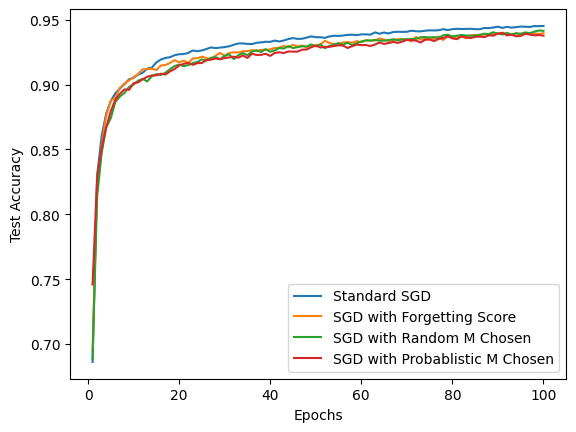

In [ ]:
# Plot test accuracies
plt.plot(range(1, epochs + 1), test_accuracies_standard, label='Standard SGD')
plt.plot(range(1, epochs + 1), test_accuracies_forgetting, label='SGD with Forgetting Score')
plt.plot(range(1, epochs + 1), test_accuracies_random, label='SGD with Random M Chosen')
plt.plot(range(1, epochs + 1), test_accuracies_p, label='SGD with Probablistic M Chosen')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

In [ ]:
# Plot test accuracies
for model_name, accuracies in test_accuracies.items():
  if model_name == 'standard':
    continue
  x_epochs = np.arange(0, epochs)
  plt.plot(x_epochs, accuracies, label=model_name)
plt.title(f'Test Accuracy on CIFAR-10 with n_b/n_B = {B_b}')
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(forgetting_probabilistic, label='probabilistic')
plt.plot(forgetting_random, label='random')
plt.xlabel('Epochs')
plt.ylabel('Average Forgetting Score')
plt.title('Average Forgetting Score of Selected Mini-Batch')
plt.legend()
plt.show()

In [ ]:
# Plot test accuracies
for model_name, accuracies in test_accuracies.items():

  x_epochs = np.arange(0, epochs)
  plt.plot(x_epochs, accuracies, label=model_name)
plt.title(f'Test Accuracy on CIFAR-10 with n_b/n_B = {B_b}')
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

In [ ]:
B_b = 0.1
for model_name, accuracies in test_accuracies.items():
  if model_name == 'standard':
    x_epochs = np.arange(0, epochs)

  else:
    x_epochs = np.arange(0, epochs) * B_b
  plt.plot(x_epochs, accuracies, label=model_name)
plt.title(f'Test Accuracy on CIFAR-10 with n_b/n_B = {B_b}')
plt.xlim(0, 10)
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

#Noisy Examples (ended up not covering this in paper/presentation)
Forgetting score is not robust to noise. Going to randomly flip 20% of labels in training dataset and run models again on test set, see difference. Besides function mostly everything is the same as before



In [ ]:
# Function to introduce label noise
def introduce_label_noise(targets, noise_ratio=0.2):
    num_samples = len(targets)
    num_noisy_samples = int(noise_ratio * num_samples)
    noisy_indices = random.sample(range(num_samples), num_noisy_samples)

    for idx in noisy_indices:
        new_label = random.randint(0, 9)  # Assuming there are 10 classes
        targets[idx] = new_label

    return targets

# Function for testing the model on the test dataset
def test_model(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy

# Main function to run the training
def run_training(batch_size, epochs):
    # Check for available device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    noise_ratio = 0.6 #change for percentage of flipped
    train_dataset.targets = introduce_label_noise(train_dataset.targets, noise_ratio) #change labels

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    prev_acc = torch.zeros_like(train_dataset.targets)
    forgetting_T = torch.zeros_like(train_dataset.targets)
    forgetting_T_p = torch.zeros_like(train_dataset.targets)

    # Initialize models and optimizers
    standard_model = SimpleNN().to(device)
    forgetting_model = SimpleNN().to(device)
    random_model = SimpleNN().to(device)
    p_model = SimpleNN().to(device)

    optimizer_standard = optim.SGD(standard_model.parameters(), lr=0.01)
    optimizer_forgetting = optim.SGD(forgetting_model.parameters(), lr=0.01)
    optimizer_random = optim.SGD(random_model.parameters(), lr=0.01)
    optimizer_p = optim.SGD(p_model.parameters(), lr=0.01)

    # Lists to store test accuracies
    test_accuracies_standard = []
    test_accuracies_forgetting = []
    test_accuracies_random = []
    test_accuracies_p = []

    # Choose m examples from batch b
    m = 10

    # Train models
    for epoch in tqdm(range(1, epochs + 1), desc='Epochs'):

        print(f"\nEpoch {epoch} - Standard SGD")
        train_standard_sgd(standard_model, device, train_loader, optimizer_standard, epoch)

        print(f"\nTesting - Standard SGD")
        test_acc_standard = test_model(standard_model, device, test_loader)
        test_accuracies_standard.append(test_acc_standard)

        print(f"\nEpoch {epoch} - Standard SGD w/ Random M Examples")
        train_standard_sgd_random_m(random_model, device, train_loader, optimizer_random, epoch, m)

        print(f"\nTesting - Standard SGD w/ Random M Examples")
        test_acc_random = test_model(random_model, device, test_loader)
        test_accuracies_random.append(test_acc_random)

        print(f"\nEpoch {epoch} - SGD with Forgetting Score")
        avg_forgetting_score = train_with_forgetting_score(forgetting_model, device, train_loader, optimizer_forgetting, epoch, prev_acc, forgetting_T, m)
        print(f"Total Forgetting Score for Epoch {epoch}: {avg_forgetting_score:.4f}")

        print(f"\nTesting - SGD with Forgetting Score")
        test_acc_forgetting = test_model(forgetting_model, device, test_loader)
        test_accuracies_forgetting.append(test_acc_forgetting)

        print(f"\nEpoch {epoch} - Standard SGD w/ Probabilistic M Examples")
        train_with_forgetting_score_probabilistic(p_model, device, train_loader, optimizer_p, epoch, prev_acc, forgetting_T_p, m)

        print(f"\nTesting - Standard SGD w/ Probabilistic M Examples")
        test_acc_p = test_model(p_model, device, test_loader)
        test_accuracies_p.append(test_acc_p)

    return test_accuracies_standard, test_accuracies_forgetting, test_accuracies_random, test_accuracies_p


# Parameters for training
batch_size = 64
epochs = 5

# Start training
test_accuracies_standard, test_accuracies_forgetting, test_accuracies_random, test_accuracies_p = run_training(batch_size, epochs)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1 - Standard SGD
Epoch 1 [0/60000]: Loss: 2.317761
Epoch 1 [6400/60000]: Loss: 2.242032
Epoch 1 [12800/60000]: Loss: 2.175766
Epoch 1 [19200/60000]: Loss: 2.140296
Epoch 1 [25600/60000]: Loss: 2.112534
Epoch 1 [32000/60000]: Loss: 2.100573
Epoch 1 [38400/60000]: Loss: 1.906793
Epoch 1 [44800/60000]: Loss: 2.081009
Epoch 1 [51200/60000]: Loss: 2.029365
Epoch 1 [57600/60000]: Loss: 1.981263

Testing - Standard SGD
Test Accuracy: 0.8704

Epoch 1 - Standard SGD w/ Random M Examples
Epoch 1 [0/60000]: Loss: 2.267860
Epoch 1 [6400/60000]: Loss: 2.095612
Epoch 1 [12800/60000]: Loss: 2.009849
Epoch 1 [19200/60000]: Loss: 1.960311
Epoch 1 [25600/60000]: Loss: 1.707861
Epoch 1 [32000/60000]: Loss: 2.011020
Epoch 1 [38400/60000]: Loss: 2.628870
Epoch 1 [44800/60000]: Loss: 2.085417
Epoch 1 [51200/60000]: Loss: 2.437921
Epoch 1 [57600/60000]: Loss: 2.399275

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.8385

Epoch 1 - SGD with Forgetting Score
Epoch: 1, Batch: 937, Average F

Epochs:  20%|██        | 1/5 [01:09<04:39, 69.92s/it]

Test Accuracy: 0.8500

Epoch 2 - Standard SGD
Epoch 2 [0/60000]: Loss: 2.253979
Epoch 2 [6400/60000]: Loss: 1.807081
Epoch 2 [12800/60000]: Loss: 1.957475
Epoch 2 [19200/60000]: Loss: 2.146465
Epoch 2 [25600/60000]: Loss: 2.002632
Epoch 2 [32000/60000]: Loss: 2.077731
Epoch 2 [38400/60000]: Loss: 2.060004
Epoch 2 [44800/60000]: Loss: 1.972259
Epoch 2 [51200/60000]: Loss: 2.119624
Epoch 2 [57600/60000]: Loss: 1.796080

Testing - Standard SGD
Test Accuracy: 0.8821

Epoch 2 - Standard SGD w/ Random M Examples
Epoch 2 [0/60000]: Loss: 2.459179
Epoch 2 [6400/60000]: Loss: 2.111139
Epoch 2 [12800/60000]: Loss: 1.985273
Epoch 2 [19200/60000]: Loss: 1.671373
Epoch 2 [25600/60000]: Loss: 1.963234
Epoch 2 [32000/60000]: Loss: 1.951672
Epoch 2 [38400/60000]: Loss: 2.094365
Epoch 2 [44800/60000]: Loss: 2.330163
Epoch 2 [51200/60000]: Loss: 1.925199
Epoch 2 [57600/60000]: Loss: 2.003865

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.8552

Epoch 2 - SGD with Forgetting Score
Epoch: 2,

Epochs:  40%|████      | 2/5 [02:21<03:32, 70.84s/it]

Test Accuracy: 0.8765

Epoch 3 - Standard SGD
Epoch 3 [0/60000]: Loss: 1.902435
Epoch 3 [6400/60000]: Loss: 1.806588
Epoch 3 [12800/60000]: Loss: 2.008523
Epoch 3 [19200/60000]: Loss: 1.970950
Epoch 3 [25600/60000]: Loss: 2.108771
Epoch 3 [32000/60000]: Loss: 1.864465
Epoch 3 [38400/60000]: Loss: 1.813164
Epoch 3 [44800/60000]: Loss: 2.091045
Epoch 3 [51200/60000]: Loss: 2.078530
Epoch 3 [57600/60000]: Loss: 1.899579

Testing - Standard SGD
Test Accuracy: 0.9019

Epoch 3 - Standard SGD w/ Random M Examples
Epoch 3 [0/60000]: Loss: 1.615173
Epoch 3 [6400/60000]: Loss: 2.082630
Epoch 3 [12800/60000]: Loss: 2.442803
Epoch 3 [19200/60000]: Loss: 1.894135
Epoch 3 [25600/60000]: Loss: 2.018643
Epoch 3 [32000/60000]: Loss: 2.048639
Epoch 3 [38400/60000]: Loss: 2.036163
Epoch 3 [44800/60000]: Loss: 1.807674
Epoch 3 [51200/60000]: Loss: 1.670411
Epoch 3 [57600/60000]: Loss: 2.136836

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.8469

Epoch 3 - SGD with Forgetting Score
Epoch: 3,

Epochs:  60%|██████    | 3/5 [03:33<02:22, 71.27s/it]

Test Accuracy: 0.8873

Epoch 4 - Standard SGD
Epoch 4 [0/60000]: Loss: 1.829095
Epoch 4 [6400/60000]: Loss: 2.014514
Epoch 4 [12800/60000]: Loss: 1.805015
Epoch 4 [19200/60000]: Loss: 1.976962
Epoch 4 [25600/60000]: Loss: 2.248995
Epoch 4 [32000/60000]: Loss: 2.174577
Epoch 4 [38400/60000]: Loss: 1.969078
Epoch 4 [44800/60000]: Loss: 1.738195
Epoch 4 [51200/60000]: Loss: 1.812246
Epoch 4 [57600/60000]: Loss: 1.921973

Testing - Standard SGD
Test Accuracy: 0.9028

Epoch 4 - Standard SGD w/ Random M Examples
Epoch 4 [0/60000]: Loss: 1.880586
Epoch 4 [6400/60000]: Loss: 1.702520
Epoch 4 [12800/60000]: Loss: 1.902178
Epoch 4 [19200/60000]: Loss: 2.121696
Epoch 4 [25600/60000]: Loss: 2.215321
Epoch 4 [32000/60000]: Loss: 2.085711
Epoch 4 [38400/60000]: Loss: 2.259141
Epoch 4 [44800/60000]: Loss: 1.780069
Epoch 4 [51200/60000]: Loss: 1.854214
Epoch 4 [57600/60000]: Loss: 2.088873

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.8644

Epoch 4 - SGD with Forgetting Score
Epoch: 4,

Epochs:  80%|████████  | 4/5 [04:45<01:11, 71.50s/it]

Test Accuracy: 0.8890

Epoch 5 - Standard SGD
Epoch 5 [0/60000]: Loss: 1.903123
Epoch 5 [6400/60000]: Loss: 2.013628
Epoch 5 [12800/60000]: Loss: 2.181628
Epoch 5 [19200/60000]: Loss: 2.085342
Epoch 5 [25600/60000]: Loss: 1.913949
Epoch 5 [32000/60000]: Loss: 2.212506
Epoch 5 [38400/60000]: Loss: 2.037537
Epoch 5 [44800/60000]: Loss: 2.041625
Epoch 5 [51200/60000]: Loss: 1.993554
Epoch 5 [57600/60000]: Loss: 1.812916

Testing - Standard SGD
Test Accuracy: 0.9074

Epoch 5 - Standard SGD w/ Random M Examples
Epoch 5 [0/60000]: Loss: 1.947698
Epoch 5 [6400/60000]: Loss: 1.705682
Epoch 5 [12800/60000]: Loss: 1.713400
Epoch 5 [19200/60000]: Loss: 1.397840
Epoch 5 [25600/60000]: Loss: 2.564916
Epoch 5 [32000/60000]: Loss: 2.129356
Epoch 5 [38400/60000]: Loss: 1.094178
Epoch 5 [44800/60000]: Loss: 1.798024
Epoch 5 [51200/60000]: Loss: 1.669081
Epoch 5 [57600/60000]: Loss: 1.893130

Testing - Standard SGD w/ Random M Examples
Test Accuracy: 0.8821

Epoch 5 - SGD with Forgetting Score
Epoch: 5,

Epochs: 100%|██████████| 5/5 [06:00<00:00, 72.16s/it]

Test Accuracy: 0.8919


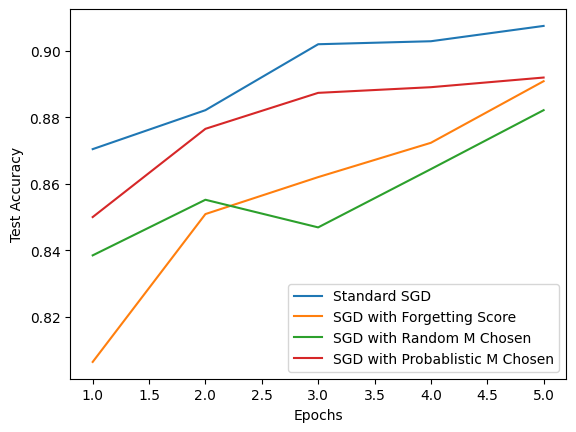

In [ ]:
# Plot test accuracies
plt.plot(range(1, epochs + 1), test_accuracies_standard, label='Standard SGD')
plt.plot(range(1, epochs + 1), test_accuracies_forgetting, label='SGD with Forgetting Score')
plt.plot(range(1, epochs + 1), test_accuracies_random, label='SGD with Random M Chosen')
plt.plot(range(1, epochs + 1), test_accuracies_p, label='SGD with Probablistic M Chosen')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()